### Windsat training   
Training notebook with windsat dataset, to experiment with model architecture, sample selection an hyperparameters.

In [25]:
import xbatcher as xb
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import History

import sys
sys.path.append("../../")

from src.processing import windsat_datacube
from src.model import transform_batch, xy_split, default_model, default_model, plot_history

In [5]:
# default model can be overrrided later.
model = default_model()

def training_step(training_batch: pd.DataFrame, history: History=None ) -> History :
    """ 
    Single training step with a dataframe 2000 samples long. returned expanded history
    """
    X, y = xy_split(training_batch)
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 13)
    batch_history = model.fit(x_train, y_train, epochs=1, validation_data=(x_test,y_test))

    # Manage the history of each training run
    if history is None:
        history = batch_history
    else:
        for key in history.history.keys():
            history.history[key].extend(batch_history.history[key])

    return history

In [6]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [7]:
# Preprocess and selec the dataset
ascds = ds.sel(swath_sector = 0)

In [14]:
# Xbatcher generator:
bgen = xb.BatchGenerator(
    ds=ascds,
    input_dims ={"latitude_grid":50,"longitude_grid":50},
    )
print(len(bgen))
batch_example = bgen[0]
batch_example

392


<xarray.Dataset> Size: 7MB
Dimensions:         (longitude_grid: 50, sample: 84, latitude_grid: 50)
Coordinates:
    lat             (latitude_grid) float32 200B -89.88 -89.62 ... -77.88 -77.62
    lon             (longitude_grid) float32 200B 180.1 180.4 ... 192.1 192.4
  * sample          (sample) object 672B MultiIndex
  * day_number      (sample) int32 336B 1 1 1 1 2 2 2 2 ... 20 20 20 21 21 21 21
  * frequency_band  (sample) int64 672B 0 0 1 1 0 0 1 1 0 ... 1 0 0 1 1 0 0 1 1
  * polarization    (sample) int64 672B 0 1 0 1 0 1 0 1 0 ... 1 0 1 0 1 0 1 0 1
Dimensions without coordinates: longitude_grid, latitude_grid
Data variables: (12/13)
    longitude       (sample, longitude_grid) float32 17kB 180.1 180.4 ... 192.4
    latitude        (sample, latitude_grid) float32 17kB -89.88 ... -77.62
    node            (sample) int32 336B 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    frequency_vpol  (sample) float32 336B 18.68 18.68 37.02 ... 37.02 37.02
    frequency_hpol  (sample) float32 336B 18.73 18.73 37.02 ... 37.02 37.02
    eia_nominal     (sample) float32 336B 55.57 55.57 53.2 ... 55.57 53.2 53.2
    ...              ...
    eaa             (sample, latitude_grid, longitude_grid) float32 840kB nan...
    eia             (sample, latitude_grid, longitude_grid) float32 840kB nan...
    tbtoa           (sample, latitude_grid, longitude_grid) float32 840kB nan...
    quality_flag    (sample, latitude_grid, longitude_grid) int32 840kB 1 ......
    surtep_ERA5     (sample, latitude_grid, longitude_grid) float32 840kB nan...
    airtep_ERA5     (sample, latitude_grid, longitude_grid) float32 840kB nan...
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [15]:
# We will convert the batches into dataframes for training with this custom function
batch_df = batch_example.to_dataframe()
batch_df = transform_batch(batch_df)
batch_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
72,1,262.643127,-0.993323,-0.002182,192.187500,122.759995,210.399994,202.434998,0.391940,0.393823
73,1,262.646576,-0.992810,-0.002182,192.187500,122.759995,210.399994,204.514999,0.391940,0.393790
74,1,262.563843,-0.992278,-0.002182,192.187500,122.759995,210.399994,202.949997,0.391940,0.393743
75,1,262.615356,-0.991727,-0.002182,192.187500,122.759995,210.399994,198.882492,0.391940,0.393689
76,1,262.720886,-0.991158,-0.002182,192.187500,122.759995,210.399994,195.087494,0.391940,0.393636
...,...,...,...,...,...,...,...,...,...,...
70575,21,258.139313,-0.980357,-0.214309,182.845001,105.464996,207.964996,182.102493,0.239591,0.239302
70576,21,258.867554,-0.979487,-0.214309,182.845001,105.464996,207.964996,151.677490,0.239591,0.239175
70577,21,265.871704,-0.978599,-0.214309,182.845001,105.464996,207.964996,137.112503,0.239591,0.239051
70578,21,272.654419,-0.977692,-0.214309,182.845001,105.464996,207.964996,142.352493,0.239591,0.238903


In [16]:
#OPTIONAL: define a custom model to train:
n_vars = batch_df.shape[1] - 1 # dont count the prediction column.

model = Sequential([
    Input((n_vars,)),
    BatchNormalization(),
    Dense(30,activation="relu", name = "hiddenLayer1"),
    Dense(20,activation="relu", name = "hiddenLayer2"),
    Dense(10,activation="relu", name = "hiddenLayer3"),
    Dense(1,activation="relu", name = "outputLayer")
])

model.compile(
    optimizer = "adam",
    loss ="mse",
    metrics = ["mse"]
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

In [17]:
# Leftovers training loop
history = None
min_samples = 32000 # model batch training is 32 by default, so this makes nice numbers appear.
leftovers = pd.DataFrame()

# TODO: make this sequential process into a parallel one (retrieve data - train model)
for i, batch in enumerate(bgen):
    batch = batch.to_dataframe()
    batch = transform_batch(batch)

    batch = pd.concat([leftovers,batch])
    batch.reset_index()

    if batch.shape[0] < min_samples:
        leftovers = pd.concat([leftovers,batch])
        continue

    training_batch, leftovers = batch[:min_samples], batch[min_samples:]

    history = training_step(training_batch, history)

    while leftovers.shape[0] > min_samples:
        training_batch, new_leftovers = leftovers[:min_samples], leftovers[min_samples:]
        history = training_step(training_batch, history)
        leftovers = new_leftovers


    print(f"Standard Batch {i} out of {len(bgen)} - {100*i/len(bgen):.2f}%")

900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.2902 - mse: 12.2902 - val_loss: 10.2246 - val_mse: 10.2246
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.2352 - mse: 13.2352 - val_loss: 10.3548 - val_mse: 10.3548
Standard Batch 328 out of 392 - 83.67%
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 26.1451 - mse: 26.1451 - val_loss: 21.6504 - val_mse: 21.6504
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 38.0942 - mse: 38.0942 - val_loss: 34.8711 - val_mse: 34.8711
Standard Batch 329 out of 392 - 83.93%
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 29.8815 - mse: 29.8815 - val_loss: 26.6896 - val_mse: 26.6896
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 27.2783 - mse: 27.2783 - val_loss: 25.3061 - val_mse: 25.3061
Standard Batch 330 out of 392 - 84.18%
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - loss: 20.7725 - mse: 20.7725 - val_loss: 19.1597 - val_mse: 19.1597
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 32.4980 - mse: 32.4980 - val_loss: 27.0622 - val_mse: 2

In [18]:
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")
weights_path = f"../../models/{now}.weights.h5"
weights_path

'../../models/2024_05_21T110752.weights.h5'

In [19]:
# Save FINAL model weights and history data.
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")

weights_path = f"../../models/{now}.weights.h5"
model.save_weights(weights_path)

history_path = f"../../models/{now}.json"
with open(history_path, "wb") as file:
    pickle.dump(history, file)

AttributeError: 'Axes' object has no attribute 'ylabel'

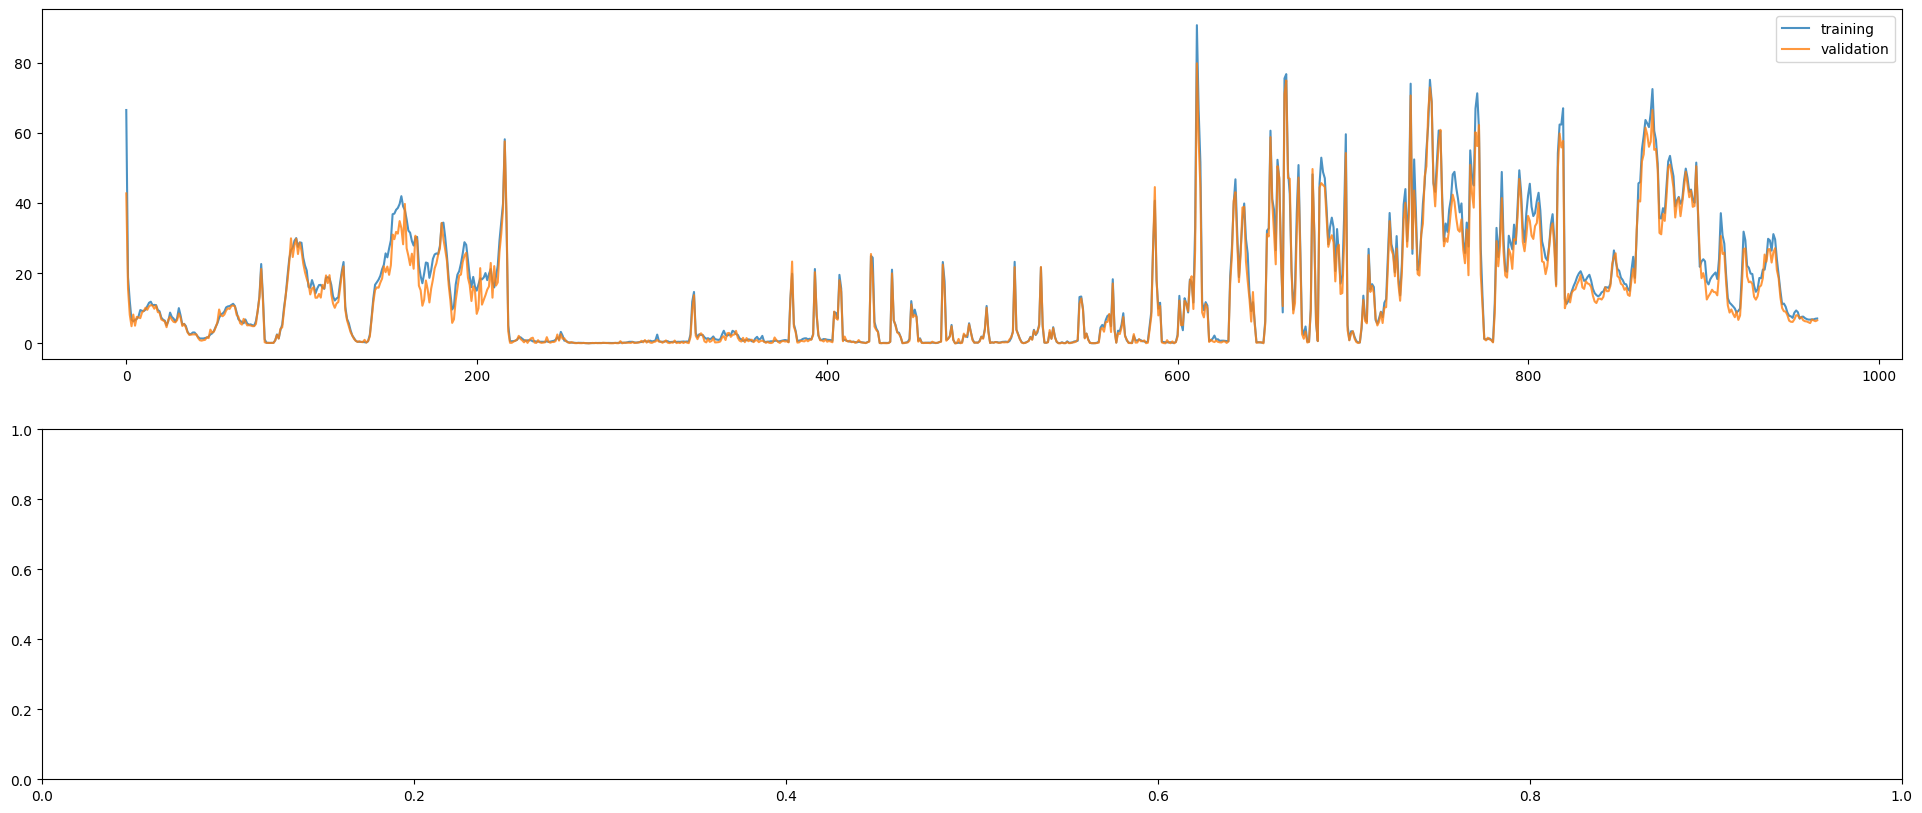

In [26]:
plot_history(history)